In [1]:
import torch
from torch import nn
from monotonenorm import MonotonicLayer, GroupSort, RMSNorm
from matplotlib import pyplot as plt

In [2]:
# Example usage

input_dim = [3, 16, 32]
output_dim = [*input_dim[1:], 1]
model = nn.Sequential(
    *[
        layer
        for i in range(3)
        for layer in (
            MonotonicLayer(input_dim[i], output_dim[i]),
            GroupSort(2),
            RMSNorm(output_dim[i]),
        )
    ][:-2]
)
model_base = nn.Sequential(
    *[
        layer
        for i in range(3)
        for layer in (nn.Linear(input_dim[i], output_dim[i]), GroupSort(2))
    ][:-1]
)

X = torch.randn(100, input_dim[0])
X[:, 1:] = 0
Y = model(X)
y_base = model_base(X)

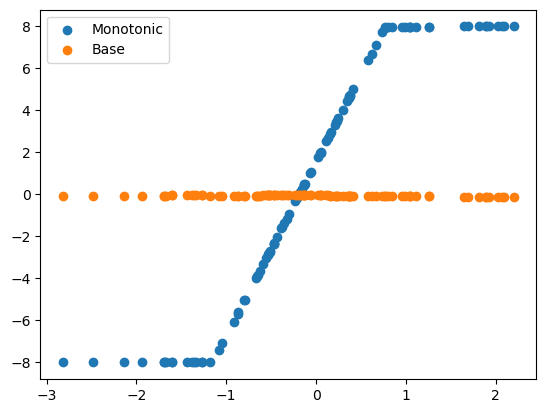

In [3]:
plt.scatter(X[:, 0], Y[:, 0].detach().numpy(), label="Monotonic")
plt.scatter(X[:, 0], y_base[:, 0].detach().numpy(), label="Base")
plt.legend()

**sanity check:** Let's take a look the RMS of intermediate representations 

In [4]:
x = X[:3, :]
for layer in model:
    x = layer(x)
    if isinstance(layer, MonotonicLayer):
        print(x)
        print("rms:", torch.sqrt(torch.mean(x ** 2, axis=-1)).detach())

tensor([[ 1.0573,  1.1158,  0.8166,  1.0774,  1.1009,  1.1094,  1.2599,  0.9287,
          1.2844,  0.7584,  1.1598,  1.0918,  1.0632,  1.1966,  1.1345,  1.1057],
        [ 0.2662,  0.2939,  0.1220,  0.3035,  0.2721,  0.3844,  0.4328,  0.2179,
          0.4802, -0.0474,  0.4168,  0.2622,  0.2433,  0.3728,  0.3457,  0.3442],
        [-0.1807, -0.1703, -0.2704, -0.1336, -0.1961, -0.0252, -0.0345, -0.1836,
          0.0259, -0.5026, -0.0029, -0.2064, -0.2199, -0.0925, -0.0999, -0.0860]],
       grad_fn=<DivBackward0>)
rms: tensor([1.0873, 0.3194, 0.1931])
tensor([[ 1.8830,  2.0218,  1.9866,  1.9047,  2.0510,  2.0587,  1.9847,  1.9607,
          1.9087,  1.9692,  2.0689,  1.9749,  2.0449,  1.9417,  2.0664,  1.9459,
          2.0474,  1.9401,  1.8692,  1.9364,  1.9064,  2.0892,  2.0715,  1.9964,
          2.0523,  1.8704,  1.9575,  1.9756,  1.9282,  2.0933,  1.8683,  2.0690,
          1.9111,  1.9533,  1.9937,  2.1059,  2.0024,  1.8945,  2.0284,  2.0613,
          1.8947,  1.9120,  2.0452, 

## Synthetic toy data
Let's train on some toy data to see how the model works. We'll use a simple regression problem with two input two outputs.

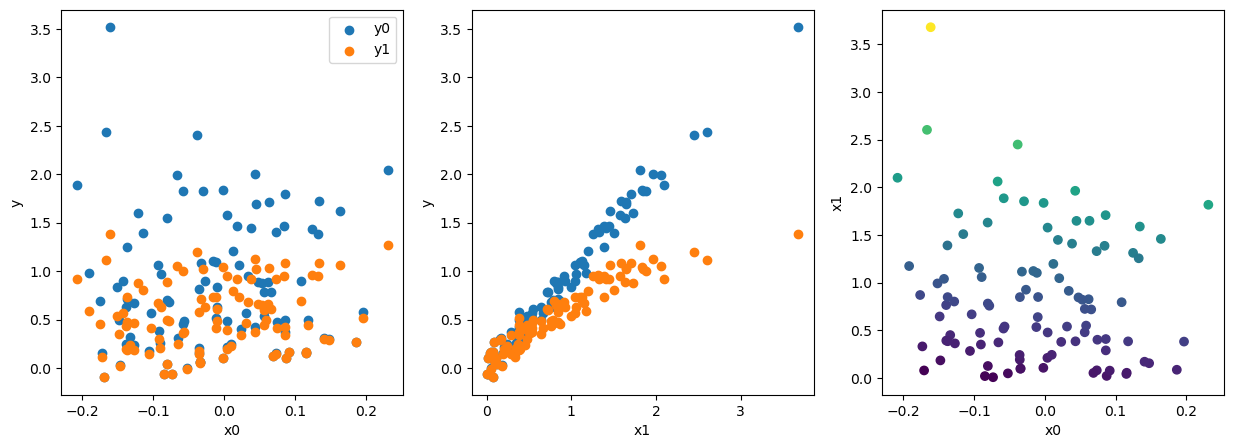

In [5]:
X  = torch.randn(100, 2)
X[:, 0] = X[:, 0] * 0.1
X[:, 1] = torch.abs(X[:, 1])
y = torch.vstack([X[:,0] + X[:,1], X[:,0] + torch.log(X[:,1] + 1)]).T

def plot_data():
    # plot the data
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))
    ax0.scatter(X[:,0], y[:,0], label="y0")
    ax0.scatter(X[:,0], y[:,1], label="y1")
    ax0.set_xlabel("x0")
    ax0.set_ylabel("y")

    ax1.scatter(X[:, 1], y[:, 0], label="y0")
    ax1.scatter(X[:, 1], y[:, 1], label="y1")
    ax1.set_xlabel("x1")
    ax1.set_ylabel("y")

    # plot y[0] as a function of x[0] and x[1]
    ax2.scatter(X[:, 0], X[:, 1], c=y[:, 0], label="y0")
    ax2.set_xlabel("x0")
    ax2.set_ylabel("x1")
    ax0.legend()
    return fig, (ax0, ax1, ax2)
plot_data()
plt.show()

Now we train the models

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
device = "cuda:0"
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [7]:
input_dim = [2, 32, 32]
output_dim = [*input_dim[1:], 2]
model = nn.Sequential(
    *[
        layer
        for i in range(3)
        for layer in (
            MonotonicLayer(input_dim[i], output_dim[i]),
            GroupSort(2),
            # nn.LayerNorm(output_dim[i]),
            RMSNorm(output_dim[i]),
        )
    ][:-2]
).to(device)
model_base = nn.Sequential(
    *[
        layer
        for i in range(3)
        for layer in (nn.Linear(input_dim[i], output_dim[i]), GroupSort(2))
    ][:-1]
).to(device)


In [8]:
import tqdm.notebook as tqdm

def train_model(model, X_train, y_train, X_test, y_test):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in (pbar:=tqdm.trange(10000)):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train) ** 2)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred_test = model(X_test)
            loss_test = torch.mean((y_pred_test - y_test) ** 2)
            pbar.set_description(f"loss: {loss.item():.3f}, test loss: {loss_test.item():.3f}")

    
    return model

In [9]:
train_model(model, X_train, y_train, X_test, y_test)
train_model(model_base, X_train, y_train, X_test, y_test)
print("Done!")
# plot the data

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Done!


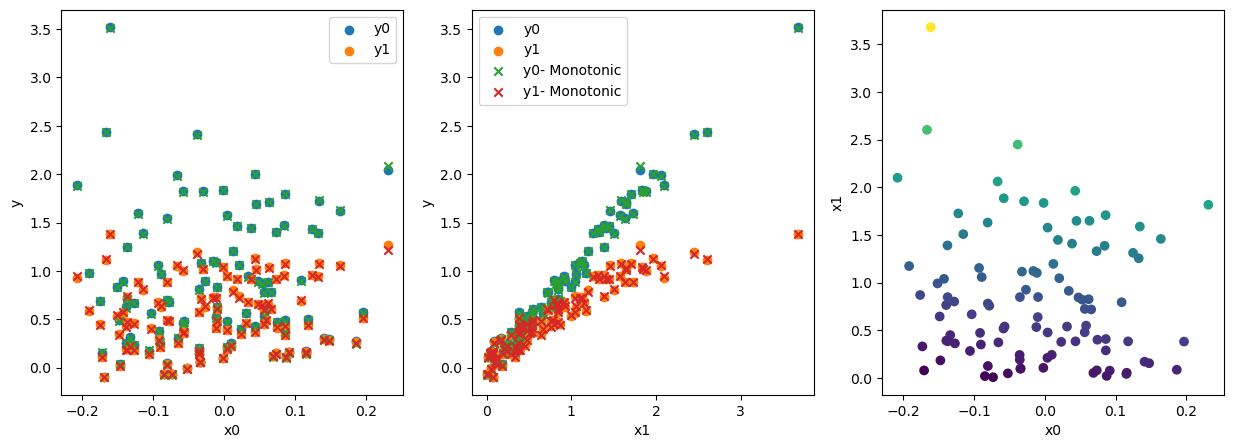

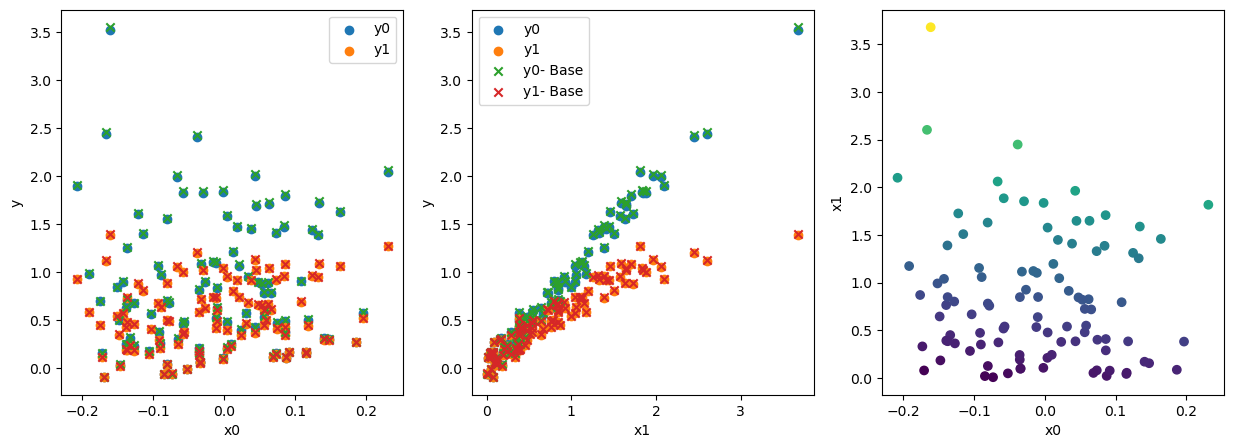

In [10]:
fig, (ax0, ax1, ax2) = plot_data()
# plot the model
def plot_model(model, name):
    pred = model(X.to(device)).detach().cpu().numpy()
    ax0.scatter(X[:, 0], pred[:, 0], label=f"y0- {name}", marker="x")
    ax0.scatter(X[:, 0], pred[:, 1], label=f"y1- {name}", marker="x")
    ax1.scatter(X[:, 1], pred[:, 0], label=f"y0- {name}", marker="x")
    ax1.scatter(X[:, 1], pred[:, 1], label=f"y1- {name}", marker="x")
    ax1.legend()
plot_model(model, "Monotonic")
plt.show()
fig, (ax0, ax1, ax2) = plot_data()
plot_model(model_base, "Base")